In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install "pillow<7"

In [ ]:
!pip install torch 

##Preprocessing the data and installing packages 

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [ ]:
labels = {
        0: 'badminton',
        1: 'baseball',
        2: 'basketball',
        3: 'boxing',
        4: 'chess',
        5: 'cricket',
        6: 'fencing',
        7: 'football',
        8: 'formula1',
        9: 'gymnastics',
        10: 'hockey',
        11: 'ice_hockey',
        12: 'kabaddi',
        13: 'motogp',
        14: 'shooting',
        15: 'swimming',
        16: 'table_tennis',
        17: 'tennis',
        18: 'volleyball',
        19: 'weight_lifting',
        20: 'wrestling',
        21: 'wwe'
    }
labels_1 = {
    2:'basketball', 
    15:'swimming'
}

In [ ]:
DATA_DIR ='/content/drive/MyDrive/Dataset_4'
DATA_CSV = '/content/drive/MyDrive/input/data.csv'

In [ ]:
#Reading csv
df = pd.read_csv(DATA_CSV)
print(df.head(5), "\n")
print("Shape: \t", df.shape)
print("Number of different classes: ", len(df['target'].unique()))

                                image_path  target
0    ../input/data/gymnastics/00000774.jpg     9.0
1  ../input/data/table_tennis/00000702.jpg    16.0
2       ../input/data/fencing/00000275.jpg     6.0
3      ../input/data/baseball/00000380.jpg     1.0
4       ../input/data/cricket/00000303.jpg     5.0 

Shape: 	 (13800, 2)
Number of different classes:  22


In [ ]:
# wwe vs boxing
df_4 = df[(df['target'] == 2.0) | (df['target'] == 15.0) ]
print(df_4)
#Since we're using the DATA_CSV again later on I wanted to redefine the variable with the subset that we want 
df_4.to_csv (r'df_4.csv', index = False, header=True)
DATA_CSV = '/content/df_4.csv'

                                  image_path  target
20       ../input/data/swimming/00000375.jpg    15.0
29       ../input/data/swimming/00000645.jpg    15.0
40       ../input/data/swimming/00000550.jpg    15.0
82       ../input/data/swimming/00000078.JPG    15.0
98     ../input/data/basketball/00000033.jpg     2.0
...                                      ...     ...
13767  ../input/data/basketball/00000007.jpg     2.0
13773    ../input/data/swimming/00000354.jpg    15.0
13777    ../input/data/swimming/00000151.jpg    15.0
13778    ../input/data/swimming/00000536.jpg    15.0
13791  ../input/data/basketball/00000187.jpg     2.0

[1133 rows x 2 columns]


In [ ]:
print(df_4.head(5), "\n")
print("Shape: \t", df_4.shape)
print("Number of different classes: ", len(df_4['target'].unique()))

                               image_path  target
20    ../input/data/swimming/00000375.jpg    15.0
29    ../input/data/swimming/00000645.jpg    15.0
40    ../input/data/swimming/00000550.jpg    15.0
82    ../input/data/swimming/00000078.JPG    15.0
98  ../input/data/basketball/00000033.jpg     2.0 

Shape: 	 (1133, 2)
Number of different classes:  2


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


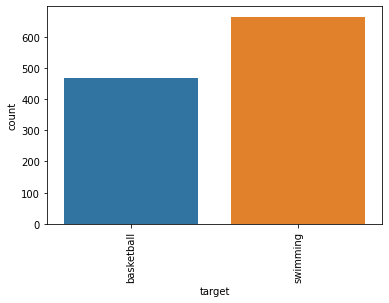

In [ ]:
ax = sns.countplot(    #fix labeling
    df_4['target'],
    
)
ax.set_xticklabels(labels_1.values(), rotation=90);

In [ ]:
dfhead = df_4.head(100)

##Images preprocessing and creating the data sets 

In [ ]:
#Images Preprocessing 
train_imgs = df_4['image_path'].tolist()
train_labels = df_4['target'].tolist()

In [ ]:
class SportsImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['image_path'], row['target']
        img_fname = self.root_dir + "/" + img_id.split('/')[-2] + "/" + img_id.split('/')[-1]
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, int(img_label)

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomCrop(256), 
        transforms.ToTensor()
    ]
)
dataset = SportsImageDataset(DATA_CSV, DATA_DIR, transform=transform)

In [ ]:
len(dataset)

1133

In [ ]:
def show_sample(img, target, prediction= False, invert=True):
    print(img.shape)
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Label (numeric):', target)
    if not prediction:
        print('Label:', labels_1[target])

torch.Size([3, 256, 256])
Label (numeric): 15
Label: swimming


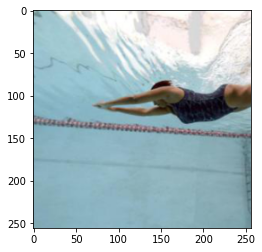

In [ ]:
show_sample(*dataset[1], invert=False)

In [ ]:
torch.manual_seed(23)

In [ ]:
val_pct = 0.2 # 0.1
val_size = int(val_pct * len(dataset))
test_pct = 0.1
test_size = int(test_pct * len(dataset))
train_size = len(dataset) - val_size - test_size

In [ ]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(794, 226, 113)

In [ ]:
batch_size = 32

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        print('images.shape:', images.shape)
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([32, 3, 256, 256])


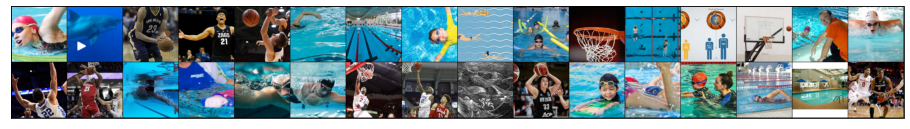

In [ ]:
show_batch(train_loader, False)   

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([64, 3, 256, 256])


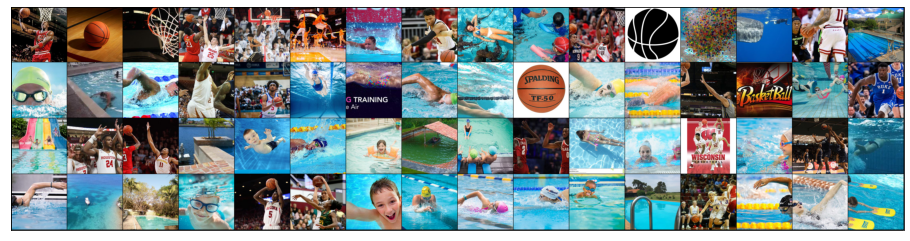

In [ ]:
show_batch(val_loader, False)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([64, 3, 256, 256])


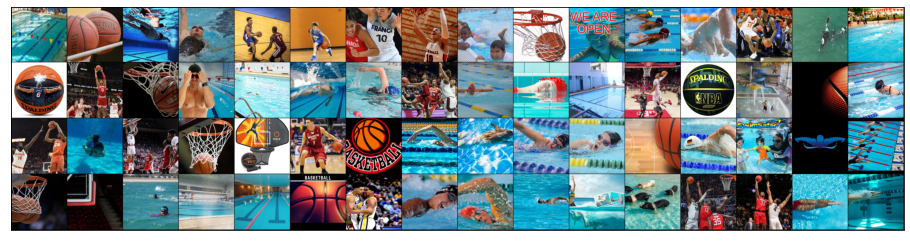

In [ ]:
show_batch(test_loader, False)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

##Models

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class SportsImageLinearModel(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 256)
        self.linear4 = nn.Linear(256, 32)
        self.linear5 = nn.Linear(32, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out

In [ ]:
input_size = 3*256*256   #issue with sizes 12288 for 64x64 196608 for 256x256, 49152 def
output_size = 22

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
model = to_device(SportsImageLinearModel(input_size, output_size), device)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):   #RMSprop or SGD or Adam
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, val_loader)]  #prelim eval if we just did one epoch
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.9613970518112183, 'val_loss': 0.12021239101886749}]

In [ ]:
from tqdm import tqdm
#now it's actually running-- will take a while
history += fit(50, 0.001, model, train_loader, val_loader)  #adjust epochs and lr as we want

  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.1574, val_loss: 0.1186, val_acc: 0.9497


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.1147, val_loss: 0.3854, val_acc: 0.9007


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.1215, val_loss: 0.1281, val_acc: 0.9658


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.1137, val_loss: 0.1675, val_acc: 0.9423


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.1504, val_loss: 0.2220, val_acc: 0.9193


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.1388, val_loss: 0.1589, val_acc: 0.9423


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.1201, val_loss: 0.2311, val_acc: 0.9272


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.1106, val_loss: 0.0934, val_acc: 0.9692


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.1033, val_loss: 0.1405, val_acc: 0.9462


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0913, val_loss: 0.1308, val_acc: 0.9501


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.1043, val_loss: 0.1337, val_acc: 0.9497


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.1279, val_loss: 0.2096, val_acc: 0.9306


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.0954, val_loss: 0.1310, val_acc: 0.9501


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.0927, val_loss: 0.1044, val_acc: 0.9653


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.1489, val_loss: 0.1142, val_acc: 0.9653


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.1125, val_loss: 0.1978, val_acc: 0.9311


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.1136, val_loss: 0.1191, val_acc: 0.9653


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.1001, val_loss: 0.1155, val_acc: 0.9614


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.0990, val_loss: 0.2018, val_acc: 0.9428


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.0853, val_loss: 0.1366, val_acc: 0.9540


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.1084, val_loss: 0.1134, val_acc: 0.9575


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.0822, val_loss: 0.2431, val_acc: 0.9350


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.1074, val_loss: 0.0971, val_acc: 0.9653


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.0844, val_loss: 0.1767, val_acc: 0.9350


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.0951, val_loss: 0.0996, val_acc: 0.9575


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.0906, val_loss: 0.0999, val_acc: 0.9658


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.1161, val_loss: 0.1045, val_acc: 0.9614


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.0866, val_loss: 0.1283, val_acc: 0.9462


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.0904, val_loss: 0.3553, val_acc: 0.9462


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.0815, val_loss: 0.0893, val_acc: 0.9653


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.0783, val_loss: 0.1961, val_acc: 0.9315


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.1002, val_loss: 0.1683, val_acc: 0.9311


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.0850, val_loss: 0.1727, val_acc: 0.9384


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.0972, val_loss: 0.1593, val_acc: 0.9423


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.0760, val_loss: 0.1829, val_acc: 0.9350


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.0712, val_loss: 0.0940, val_acc: 0.9653


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.0704, val_loss: 0.1193, val_acc: 0.9580


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.0779, val_loss: 0.1567, val_acc: 0.9462


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.0860, val_loss: 0.0889, val_acc: 0.9658


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.0684, val_loss: 0.2020, val_acc: 0.9467


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.0698, val_loss: 0.1260, val_acc: 0.9462


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.0776, val_loss: 0.0869, val_acc: 0.9614


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.7410, val_loss: 0.4723, val_acc: 0.8587


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.1663, val_loss: 0.1785, val_acc: 0.9233


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.1625, val_loss: 0.1358, val_acc: 0.9497


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.1088, val_loss: 0.1530, val_acc: 0.9272


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.1279, val_loss: 0.2670, val_acc: 0.9085


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.1276, val_loss: 0.1174, val_acc: 0.9580


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.1036, val_loss: 0.1487, val_acc: 0.9462


100%|██████████| 25/25 [00:06<00:00,  3.68it/s]


Epoch [49], train_loss: 0.1205, val_loss: 0.1850, val_acc: 0.9311
